# NLP with Disaster Tweets

In [22]:
#Load libraries

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

from keras.optimizers import Adam

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping


from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

import pickle



## Load Data

In [23]:
# Import Data

train_df = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
test_df = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")

#train_df = train_df[0:200]
#test_df = test_df[0:200]
print(train_df.head())
print(f'Train Data Shape: {train_df.shape}')
print(f'Test Data Shape: {test_df.shape}')

   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1  
Train Data Shape: (7613, 5)
Test Data Shape: (3263, 4)


In [24]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


## Exploratory Data Analysis (EDA)

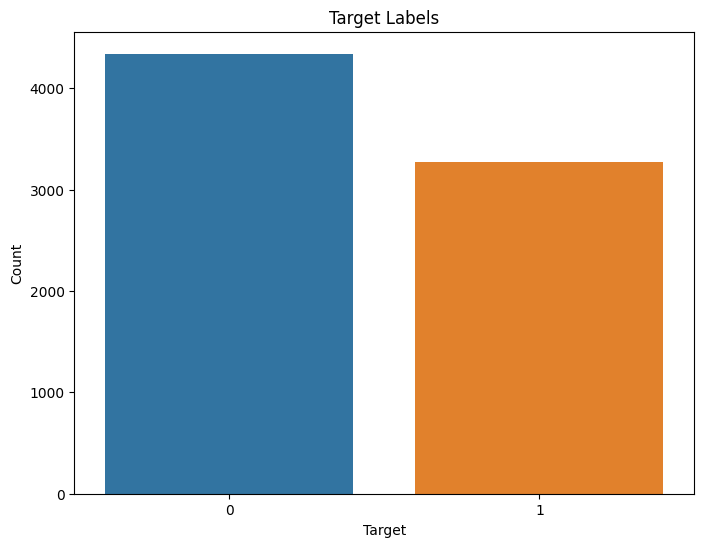

In [25]:
plt.figure(figsize=(8, 6))
sns.countplot(x='target', data=train_df)
plt.title('Target Labels')
plt.xlabel('Target')
plt.ylabel('Count')
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


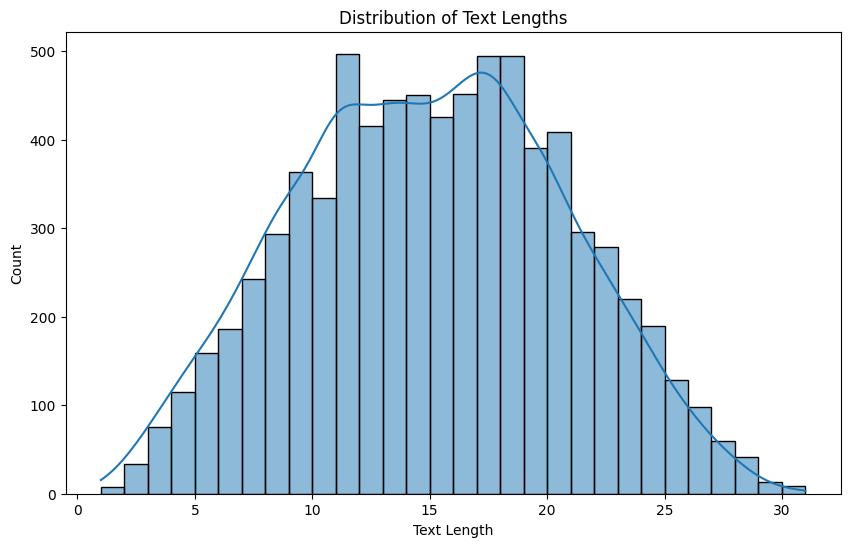

In [26]:
train_df['text_length'] = train_df['text'].apply(lambda x: len(x.split()))
plt.figure(figsize=(10, 6))
sns.histplot(train_df['text_length'], bins=30, kde=True)
plt.title('Distribution of Text Lengths')
plt.xlabel('Text Length')
plt.ylabel('Count')
plt.show()

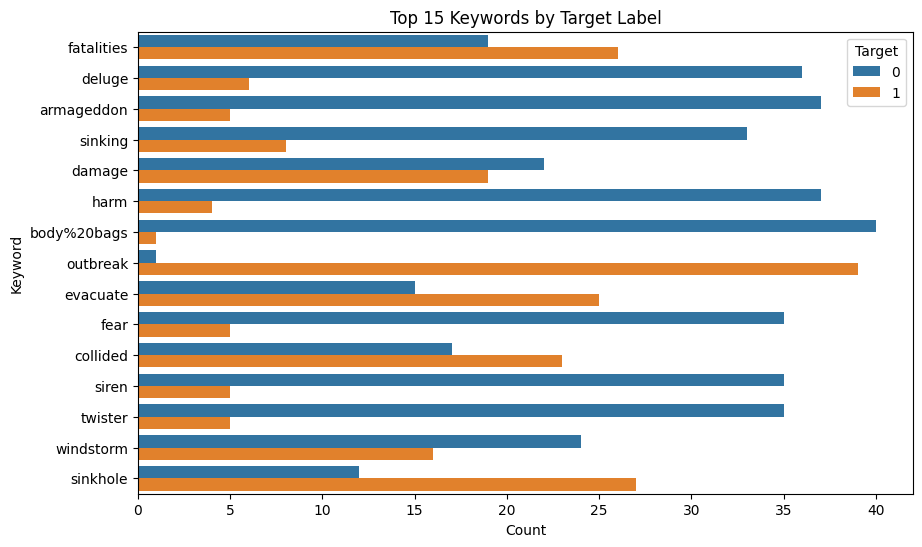

In [27]:
plt.figure(figsize=(10, 6))
sns.countplot(y='keyword', data=train_df, hue='target', order=train_df['keyword'].value_counts().iloc[:15].index)
plt.title('Top 15 Keywords by Target Label')
plt.xlabel('Count')
plt.ylabel('Keyword')
plt.legend(title='Target')
plt.show()

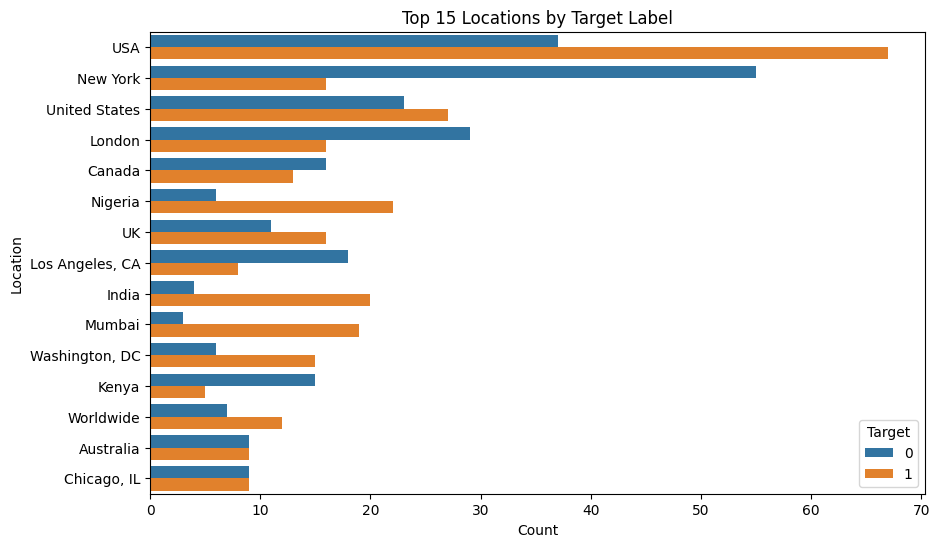

In [28]:
plt.figure(figsize=(10, 6))
sns.countplot(y='location', data=train_df, hue='target', order=train_df['location'].value_counts().iloc[:15].index)
plt.title('Top 15 Locations by Target Label')
plt.xlabel('Count')
plt.ylabel('Location')
plt.legend(title='Target')
plt.show()


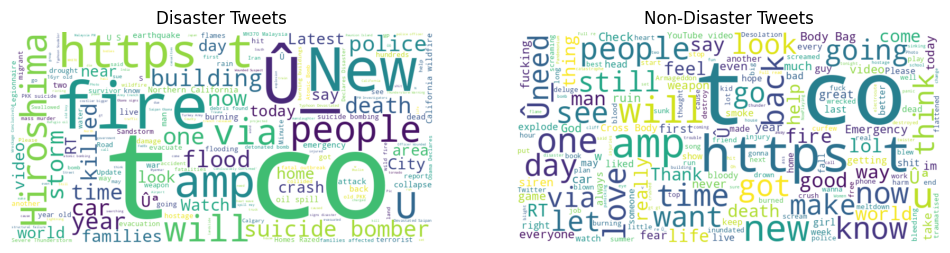

In [29]:
from wordcloud import WordCloud

disaster_tweets = train_df[train_df['target'] == 1]['text']
non_disaster_tweets = train_df[train_df['target'] == 0]['text']

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
wordcloud_disaster = WordCloud(width=800, height=400, background_color='white').generate(' '.join(disaster_tweets))
plt.imshow(wordcloud_disaster, interpolation='bilinear')
plt.title('Disaster Tweets')
plt.axis('off')

plt.subplot(1, 2, 2)
wordcloud_non_disaster = WordCloud(width=800, height=400, background_color='white').generate(' '.join(non_disaster_tweets))
plt.imshow(wordcloud_non_disaster, interpolation='bilinear')
plt.title('Non-Disaster Tweets')
plt.axis('off')

plt.show()

In [30]:
modes_keyword = train_df["keyword"].mode()[0] # Get Mode of zeroth value
modes_location = test_df["location"].mode()[0] # Get Mode of zeroth value
print(f'modes_keyword: {modes_keyword}')
print(f'modes_location: {modes_location}')

train_df["keyword"] = train_df["keyword"].fillna(modes_keyword) # Assign
train_df["location"] = train_df["location"].fillna(modes_location) # Assign

test_df["keyword"] = test_df["keyword"].fillna(modes_keyword) # Assign
test_df["location"] = test_df["location"].fillna(modes_location) # Assign

modes_keyword: fatalities
modes_location: New York


In [31]:
max_w = 10000
tokenizer = Tokenizer(num_words = max_w,oov_token = '<OOV>')
tokenizer.fit_on_texts(train_df["text"])

In [32]:
X_train, y_test = train_test_split(train_df, test_size = 0.2, random_state = 0)
print(f'y_test: {len(y_test)}')
print(f'test_df: {len(test_df)}')

y_test: 1523
test_df: 3263


## Data Cleaning

In [33]:
max_length = 200
train_seq = tokenizer.texts_to_sequences(X_train["text"])
train_padded = pad_sequences(train_seq, maxlen = max_length, padding = "post", truncating = "post")


In [34]:
test_seq = tokenizer.texts_to_sequences(y_test["text"])
test_padded = pad_sequences(test_seq, maxlen = max_length, padding = "post", truncating = "post")
print(f'Test Padded; {test_padded}')

Test Padded; [[7523   15  623 ...    0    0    0]
 [   1    1   60 ...    0    0    0]
 [  99  212 4890 ...    0    0    0]
 ...
 [   1   19  775 ...    0    0    0]
 [  69  287 1143 ...    0    0    0]
 [1394  527 1948 ...    0    0    0]]


In [35]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, mode='max', restore_best_weights=True)

## Model

In [36]:
s_model = Sequential()
s_model.add(Embedding(input_dim=max_w, output_dim=128))
s_model.add(LSTM(64, return_sequences=True))
#s_model.add(LSTM(64, return_sequences=True))
s_model.add(Dropout(0.2))
s_model.add(Dense(1, activation='sigmoid'))
s_model.add(Flatten())  # Flatten layer to 2D
#s_model.add(Dense(64, activation = 'relu'))
s_model.add(Dense(1, activation = 'relu'))
s_model.add(Dropout(0.2))
#s_model.add(Dense(32, activation = 'relu'))
s_model.add(Dense(1, activation = 'sigmoid'))
print("Model Ready!")

#flatten_layer = Flatten()(conv_output)
#dense_layer = Dense(12800, activation='relu')#(flatten_layer)
#s_model.add(dense_layer)

#model = tf.keras.Sequential([
#  layers.Embedding(max_features, embedding_dim),
#  layers.Dropout(0.2),
#  layers.GlobalAveragePooling1D(),
#  layers.Dropout(0.2),
#  layers.Dense(1, activation='sigmoid')])

Model Ready!


In [37]:
s_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [38]:
s_model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

In [39]:
print(f"y_test['target']: \n{y_test['target']}")

y_test['target']: 
311     0
4970    0
527     0
6362    0
800     0
       ..
3728    1
1657    0
6367    1
1670    0
2839    1
Name: target, Length: 1523, dtype: int64


In [ ]:

history = s_model.fit(
    train_padded, 
    X_train['target'],
    epochs = 10, 
    batch_size=256, 
    validation_data=(test_padded, y_test['target']), 
    callbacks=[early_stopping]
)

#s_model.fit(train_padded, epochs=1, validation_data=test_generator)



Epoch 1/10
 8/24 ━━━━━━━━━━━━━━━━━━━━ 4s 250ms/step - accuracy: 0.5693 - loss: 0.6832

In [ ]:
plt.figure(figsize=(6,5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
#plt.ylim(0.8, 1)
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
test_seq = tokenizer.texts_to_sequences(test_df["text"])
test_padded = pad_sequences(test_seq, maxlen=max_length, padding="post", truncating="post")


predictions = s_model.predict(test_padded)
print(f'Predictions: {predictions}')
binary_predictions = (predictions > 0.5).astype(int)

test_df['target'] = binary_predictions
print(test_df[['id', 'text', 'target']])

In [ ]:
# Predict on validation data
y_pred = s_model.predict(test_padded)
print(y_pred)
y_pred = (y_pred > 0.5).astype(int)

# Calculate F1-score
f1 = f1_score(test_df['target'], y_pred)
print(f"F1 Score: {f1}")

In [ ]:
print(y_pred)

In [ ]:
y_pred_flattened = y_pred.flatten()
output = pd.DataFrame(
    {
    'id': test_df.id, 
    'target': y_pred_flattened
    }
)
output.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")

In [ ]:
#test_df.to_csv('submission.csv', index=False)